# A convolutional neural network to identify Egyptian hieroglyphs

Can we use deeplearning to automatically classify ancient egyptian hieroglyphs? Let's try.

To train a convolutional neural network (cnn) we need data. The only useful dataset I could find was prepared by Morris Franken for his master thesis (see: https://esc.fnwi.uva.nl/thesis/centraal/files/f1329601818.pdf and https://github.com/morrisfranken/glyphreader). From this dataset we take the preprocessed images, each one containing a single hieroglyph on a gray background. All images measure 50x75 pixels.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Note: I use fastai v. 0.7

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(0)

Set the basic variables. I use a cnn that was trained on ImageNet, resnext.

In [4]:
PATH = "../../data/glyphs/"
sz = 50
arch = resnext101_64
bs = 100

I copied all the single images into the 'train' folder. Each imagename contains a code, which identifies a hieroglyph according to the Gardiner sign list. That is a standard list in Egyptology. In commandline I used `dir /b > labels_org.csv` to create a csv file containing all the images in the train folder.

In [5]:
label_csv = f'{PATH}labels_org.csv'
dataset = pd.read_csv(label_csv)
dataset.head(10)

,id
0,030000_S29.png
1,030001_D58.png
2,030002_N37.png
3,030003_Q3.png
4,030004_X1.png
5,030005_N1.png
6,030006_S34.png
7,030007_N35.png
8,030008_O50.png
9,030009_S29.png


The first image name contains 'S29'. That is the Gardiner code. Let's add a new column with just the sign code. We will save it to a new csv file which we will use to train our model.

In [6]:
new = dataset['id'].str.split('_', n=1, expand=True)
dataset['sign'] = new[1].str.split('.', n=1, expand=True)[0]
dataset.head(10)

,id,sign
0,030000_S29.png,S29
1,030001_D58.png,D58
2,030002_N37.png,N37
3,030003_Q3.png,Q3
4,030004_X1.png,X1
5,030005_N1.png,N1
6,030006_S34.png,S34
7,030007_N35.png,N35
8,030008_O50.png,O50
9,030009_S29.png,S29


In [7]:
dataset.to_csv(f'{PATH}labels.csv', index=False)

## Initial exploration

In [8]:
label_df = pd.read_csv(f'{PATH}labels.csv')

In [9]:
label_df.head()

,id,sign
0,030000_S29.png,S29
1,030001_D58.png,D58
2,030002_N37.png,N37
3,030003_Q3.png,Q3
4,030004_X1.png,X1


What is the distribution of the images in our set?

In [10]:
label_df.pivot_table(index="sign", aggfunc=len).sort_values('id', ascending=False)

,id
sign,
N35,448
M17,364
S29,265
X1,232
G43,197
G17,195
D21,183
UNKNOWN,179
I9,146


This will give us some problems. The distribution is highly unbalanced. Many of the signs don't occur often. That makes it hard or impossible to train the model. For now let's drop UNKNOWN signs.

In [11]:
unknownsigns = label_df.loc[label_df['sign'] == 'UNKNOWN']
label_df = label_df[label_df['sign'] != 'UNKNOWN']
label_df.to_csv(f'{PATH}labels.csv', index=False)

Let's also get rid of the signs that occur less than x times (minocc = minimum occurences).

In [12]:
minocc = 5
pivot_df = label_df.pivot_table(index="sign", aggfunc=len).sort_values('id', ascending=False)
morethanx_df = pivot_df[pivot_df['id'] >= minocc].reset_index()
morethanx_df

,sign,id
0,N35,448
1,M17,364
2,S29,265
3,X1,232
4,G43,197
5,G17,195
6,D21,183
7,I9,146
8,V31,133
9,E34,122


In [13]:
labelx_df = label_df[label_df['sign'].isin(morethanx_df['sign'])]
labelx_df.to_csv(f'{PATH}labels{minocc}.csv', index=False)
labelx_df

,id,sign
0,030000_S29.png,S29
1,030001_D58.png,D58
2,030002_N37.png,N37
3,030003_Q3.png,Q3
4,030004_X1.png,X1
5,030005_N1.png,N1
6,030006_S34.png,S34
7,030007_N35.png,N35
8,030008_O50.png,O50
9,030009_S29.png,S29


Let's split the set into a training set and validation set. We will use the default ratio given by fastai library.

In [14]:
n = len(list(open(f'{PATH}labels{minocc}.csv'))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [15]:
n

3860

In [16]:
len(val_idxs)

772

## Initial model

Set up the training data. Hieroglyphs sometimes are read left to right, but also right to left. We will do some horizontal flipping in our training set.

In [18]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels{minocc}.csv',
                                       val_idxs=val_idxs, tfms=tfms, bs=bs)    
    return data

In [19]:
data = get_data(sz, bs)

In [20]:
fn = PATH + data.trn_ds.fnames[0]; fn

'../../data/glyphs/train\\030001_D58.png'

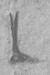

In [21]:
img = PIL.Image.open(fn); img

In [22]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [23]:
flr = learn.lr_find()

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.910771   157.699468 0.319948  



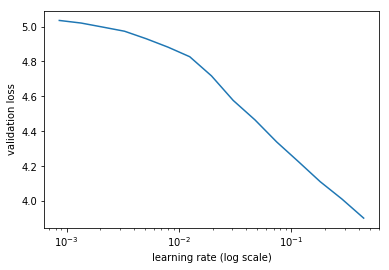

In [24]:
learn.sched.plot()

We will use a learning rate of 0.01. Since the hieroglyph images do not resemble ImageNet images that well, we want to also train the earlier weights in the model.

In [25]:
r = 1e-1
lr=np.array([r/9,r/3,r])

In [27]:
learn.fit(lr, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.791657   0.66381    0.82513   
    1      0.756319   0.635468   0.841969                                                                              
    2      0.719592   0.667857   0.80829                                                                               
    3      0.663982   0.610074   0.838083                                                                              



[array([0.61007]), 0.8380828984660805]

### Augment

Validation loss is lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [28]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.627318   0.5708     0.845855  
    1      0.622425   0.608007   0.843264                                                                              
    2      0.597683   0.572053   0.836788                                                                              
    3      0.582931   0.627488   0.835492                                                                              
    4      0.58532    0.553709   0.838083                                                                              
    5      0.551302   0.511213   0.862694                                                                              
    6      0.513696   0.506603   0.861399                                                                              



[array([0.5066]), 0.8613989711425465]

Do a test time augmentation.

In [29]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [30]:
accuracy_np(probs, y)

0.8898963730569949

In [37]:
import random

In [55]:
fn = data.val_ds.fnames[random.randint(0,len(data.val_ds.fnames))]
fn

'train\\210136_O4.png'

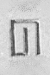

In [56]:
Image.open(PATH + fn)

In [57]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
learn.data.classes[np.argmax(preds)]

'O4'

In [36]:
len(learn.data.classes)

87

So, we see that the convolutional neural network will correctly classify hieroglyphic signs about 9 out of 10 times. That is pretty good. However, bear in mind that:
1. the dataset contains images from just one source, a book on the pyramid of Unas. It is unlikely that the trained model will be as good on images from other sources. We need a more diverse dataset to train on.
1. the images used for training were preprocessed.
1. I limited the training set to images that occurred 5 times or more, so we end up with only 87 hieroglyphs that can be recognized. The Egyptians used more than thousand signs. I also ran this with images that occur more than 10 times, and I got an accuracy of about 92%. But with only 54 signs in the set.

It would be very interesting to see if we could automatically find and classify signs in a picture containing many hieroglyphic signs. Maybe we could use something like U-NET or MASK-cnn to do that. Another challenge would be to automatically translate the hieroglyphs. Or use a RNN to suggest next signs in a string of signs.